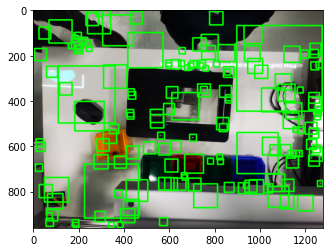

In [49]:
#Sample code for image recognition with OpenCV
import cv2
from matplotlib import pyplot as plt

# Opening image
img = cv2.imread("Images\IMG_20211021_133817.jpg")
#img = cv2.imread("image.jpg")
# OpenCV opens images as BRG
# but we want it as RGB We'll
# also need a grayscale version
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Use minSize because for not
# bothering with extra-small
# dots that would look like STOP signs
stop_data = cv2.CascadeClassifier('cascade.xml')

found = stop_data.detectMultiScale(img_gray, minSize =(20, 20))

# Don't do anything if there's
# no sign
amount_found = len(found)

if amount_found != 0:
    # There may be more than one
    # sign in the image
    for (x, y, width, height) in found:
        # We draw a green rectangle around
        # every recognized sign
        cv2.rectangle(img_rgb, (x, y),
                     (x + height, y + width),
                     (0, 255, 0), 5)

# Creates the environment of
# the picture and shows it
plt.subplot(1, 1, 1)
plt.imshow(img_rgb)
plt.show()



In [43]:
#here is code to check the output
import cv2
face_cascade=cv2.CascadeClassifier(r"C:\Users\hwb20103\OneDrive - University of Strathclyde\Desktop\temp\classifier\cascade.xml")###path of cascade file
## following is an test image u can take any image from the p folder in the temp folder and paste address of it on below line 
img= cv2.imread(r"C:\Users\hwb20103\OneDrive - University of Strathclyde\Desktop\temp\IMG_20211021_140248.jpg")###path of image file which we want to detect
resized = cv2.resize(img,(400,200))
gray=cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
faces=face_cascade.detectMultiScale(gray,6.5,17)#try to tune this 6.5 and 17 parameter to get good result 
##if not getting good result try to train new cascade.xml file again deleting other file expect p and n in temp folder

for(x,y,w,h) in faces:
    resized=cv2.rectangle(resized,(x,y),(x+w,y+h),(0,255,0),2)

cv2.imshow('img',resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

The following code is reference from:
https://medium.com/analytics-vidhya/object-detection-with-opencv-step-by-step-6c49a9cc1ff0

Object detection with the CNN model 

In [ ]:
# Neural Network
from tensorflow.keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf
# For measuring the inference time.
import time
import random
# Computer Vision
import cv2
# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
# Math
import numpy as np
# File handling
import pickle
from os import listdir
from os.path import isfile, join
import os

classes = ["box", "block", "bolt"]

def display_image(image_num):
    """
    Prints out picture of
    the image that is selected
    
    After the else statement,
    we try to use the file name
    in oder to print out the image,
    
    while the first image is used to 
    print the image directly without a 
    filename.
    """
    try:
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(images[image_num])
    except (RuntimeError, TypeError, NameError):
        print("[INFO] Could not print image")
        print("[INFO] trying something else...")
    else:
        print("[INFO] returning image...")
        # Image path - getting images on file
        image_paths = "Images/"
        image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))][image_num])  # Other way instead of the listdir function
        img = plt.imread(fname=image_select)
        plt.imshow(img)
        
# Prediction Function
def predict(model, image_num):
    # Image path - getting images on file
    image_paths = "Images/"
    image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))])[image_num] # Other way instead of the listdir function
    
    img = load_img(image_select, target_size=(300, 300))  # Loading image
    img = img_to_array(img)  # Transforming image to array
    img = img / 255  # Normalizing Image
    img = np.expand_dims(img, axis=0)  # Expanding dimensions
    predict = cnn_model.predict(img)  # Predicting the image
    pred_name = classes[np.argmax(predict)]  # Predicting the name
    prediction = str(round(predict.max() * 100, 3))
    print(display_image(image_num=image_num))
    return prediction + '%', pred_name

# Prediction Function
def predict_region_of_interest(model, proposals_used):
    """
    predicts region proposals
    """
    predict = model.predict(proposals_used)  # Predicting the image
    for proposals in predict:
        pred_name = classes[np.argmax(proposals)]  # Predicting the name
    prediction = str(round(predict.max() * 100, 3))
    print(pred_name)
    return predict

def compute_iou(boxA, boxB):
    """
    IOU is a form of 
    performance measurement
    for our object detector.
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

#  Felzenszwalb et al.
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]

# Setting a max amount of region proposals used when running selective search
max_proposals = 2000
max_proposals_infer = 100  # Search for (1) gathering training data and (2) performing inference

# initialize the input dimensions to the network
input_dimensions = (300, 300)  # 300 by 300 because that's what the CNN Model was tested on
# define the path to the output model
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)  # Loading CNN model from keras
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
min_probability = 0.90

# initialize OpenCV's selective search implementation and set the
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Input image in selective search
# Image path - getting images on file
image_num = 19
image_paths = "Images/"
image_select = image_paths + ([f for f in listdir(image_paths) if isfile(join(image_paths, f))][image_num])  # Other way instead of the listdir function
# Making image compatible with imshow
image = cv2.imread(image_select)
# load the input image (300x300) and preprocess it
image = cv2.resize(image, input_dimensions)  # Increasing image means more regions
# Setting base image that will be used
ss.setBaseImage(image)
# Choosing which selective search
ss.switchToSelectiveSearchQuality()

# run selective search on the input image
start = time.time()
rects = ss.process()  # Run Selective Search
end = time.time()
# show how along selective search took to run along with the total
# number of returned region proposals
print(f"[INFO] selective search took {np.round(end - start, decimals=3)} seconds")
print(f"[INFO] {len(rects)} total region proposals")

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:max_proposals_infer]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, input_dimensions,
        interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))
    
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float64")
boxes = np.array(boxes, dtype="int64")
print(f"[INFO] proposal shape: {proposals.shape}")
# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = predict_region_of_interest(model=cnn_model, proposals_used=proposals)  # Predicting the proposals for our desired object
                                      # Result: 100 proposals 300 by 300 image with RGB color
# Probabilty of each proposal (Region of Proposals)
print(f"[INFO] Probabiltiy Scores: {proba}")

# Obtaining the label of the current prediction from the CNN
# Empty list to store proposals
proposal_name_list = []
for proposals in proba:
    """
    For each predicted proposal
    attach the class names and 
    append it to a list.
    """
    pred_name = classes[np.argmax(proposals)]
    proposal_name_list.append(pred_name)
# find the index of all predictions that are greater
# than the minimum probability
print("[INFO] applying NMS...")
# Find the indexs where the main prediction label matches the overall image
# Get the index of the proposal that has the same class name as the overall image
idxs = [i for i, x in enumerate(proposal_name_list) if x == pred_name]
boxes = boxes[idxs]
proba = proba[idxs]
# further filter indexes by enforcing a minimum prediction
idxs = np.where(proba >= min_probability)[0]
# probability be met
boxes = boxes[idxs]
proba = proba[idxs]

# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"{np.round(prob * 100, decimals=3)}%"
    cv2.putText(clone, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
cv2.imshow("Before NMS", clone)
cv2.waitKey(0);

# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes=boxes, overlapThresh=0.5)
# loop over the bounding box indexes
for i in boxIdxs:
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = i # or boxes[0] will return 1 bb
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"{classes[np.argmax(prob)]}: {np.round(proba.max() * 100, decimals=1)}%"
    cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2.imshow("After NMS", image)
cv2.waitKey(0);